<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/inferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the second step in the split workflow on Terra

The NIFTI files generated from first step are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###Installing Packages

In [254]:
%%capture
#Installing lz4 for compression/decompression
#xvfb required for previewing Totalsegmentator png images
!apt-get install lz4 xvfb

In [255]:
%%capture
#Installing Totalsegmentator for Inference
#pyradiomics required for extracting radiomics features 
#nvidia-ml-py3 for capturing gpu utilization
!pip install TotalSegmentator pyradiomics nvidia-ml-py3

In [268]:
import glob

#Get the file path of the 
lz4_file_path = glob.glob('downloadDicomAndConvertNiftiFiles.tar.lz4')[0]
#lz4_file_path = '/content/drive/MyDrive/idc_vamsi/downloadDicomAndConvertNiftiFiles.tar.lz4'

!lz4 -d {lz4_file_path} -c | tar xvf -

#!lz4 -d /content/drive/MyDrive/idc_vamsi/downloadDicomAndConvertNiftiFiles.tar.lz4 -c | tar xvf -

###Parameters for papermill

In [257]:
converterType='dcm2niix'

###Defining Functions

In [258]:
import os
import sys
import shutil
from pathlib import Path

In [259]:
#create directory for TotalSegmentator Output files
try:
  shutil.rmtree('Inference')
except OSError:
  pass
os.mkdir('Inference')

In [260]:
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Thu Mar 23 16:39:38 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


In [261]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt
import nvidia_smi

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

In [262]:
def inferenceTotalSegmentator(series_id):
      try:
        shutil.rmtree(f'Inference/{series_id}')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')

      print("Processing series: "+series_id)  

      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      series_id_folder_path= os.path.join(curr_dir, 'dcm2niix', series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
      print(nifti_filename_path)

      start_time = time.time()
      !TotalSegmentator -i {nifti_filename_path} -o {curr_dir}/Inference/{series_id}/{series_id}.nii --ml --fast --preview  --radiomics 
      total_segmentator_time = time.time() - start_time

      start_time = time.time()     
      !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii  {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
      archiving_time = time.time() - start_time

      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}/{series_id}.nii 
      !rm -r {curr_dir}/dcm2niix/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###Total Segmentator

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105/1.3.6.1.4.1.14519.5.2.1.7009.9004.18390137279872191174337969010_2_OPA_GE_LS16_STANDARD_360_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 5.83s
Predicting...
  Predicted in 12.10s
Generating preview...
  Generated in 5.62s
Resampling...
Saving segmentations...
  Saved in 1.73s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.11s
Compressed 108539328 bytes into 2220388 bytes ==> 2.05%


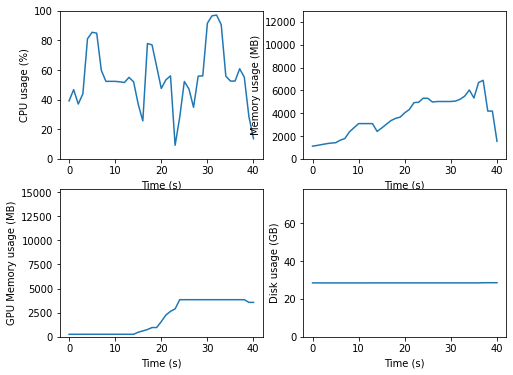

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262/1.3.6.1.4.1.14519.5.2.1.7009.9004.20702362170585978578275694726_2_OPA_GE_LSPR16_STANDARD_360_1.2_120_80_58.2_1.4_20010102000000_3.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 4.52s
Predicting...
  Predicted in 9.15s
Generating preview...
  Generated in 2.62s
Resampling...
Saving segmentations...
  Saved in 1.27s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 85208512 bytes into 1913571 bytes ==> 2.25%


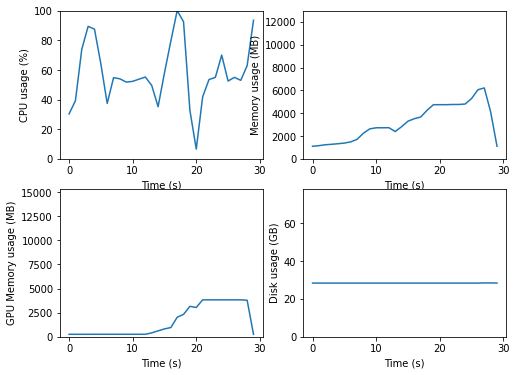

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797078712983021476504/1.3.6.1.4.1.14519.5.2.1.7009.9004.22309309779707871298302147650_2_OPA_GE_LS16_STANDARD_430_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.94s
Predicting...
  Predicted in 8.86s
Generating preview...
  Generated in 7.10s
Resampling...
Saving segmentations...
  Saved in 1.92s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 113257920 bytes into 2575734 bytes ==> 2.27%


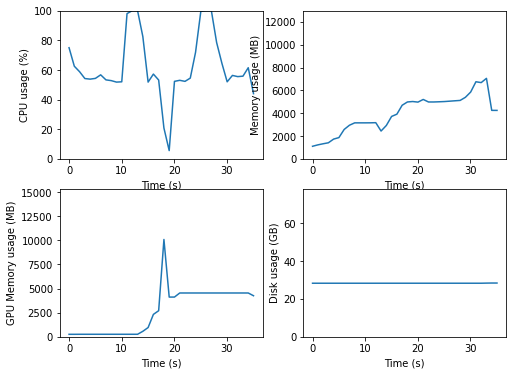

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052022558158291630814/1.3.6.1.4.1.14519.5.2.1.7009.9004.27821690605202255815829163081_2_OPA_GE_LS16_STANDARD_340_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.01s
Predicting...
  Predicted in 10.98s
Generating preview...
  Generated in 4.59s
Resampling...
Saving segmentations...
  Saved in 1.46s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 111947200 bytes into 2211095 bytes ==> 1.98%


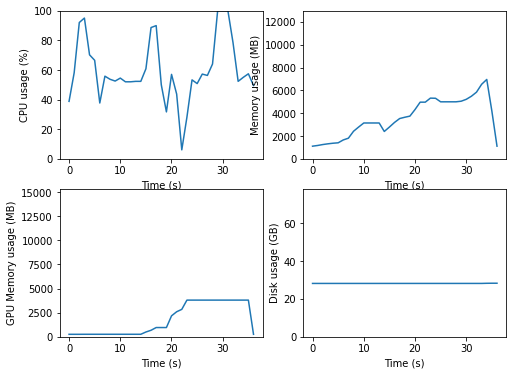

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210222351126080087655/1.3.6.1.4.1.14519.5.2.1.7009.9004.23214278521022235112608008765_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.62s
Predicting...
  Predicted in 8.72s
Generating preview...
  Generated in 3.64s
Resampling...
Saving segmentations...
  Saved in 1.70s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.11s
Compressed 119287232 bytes into 3243979 bytes ==> 2.72%


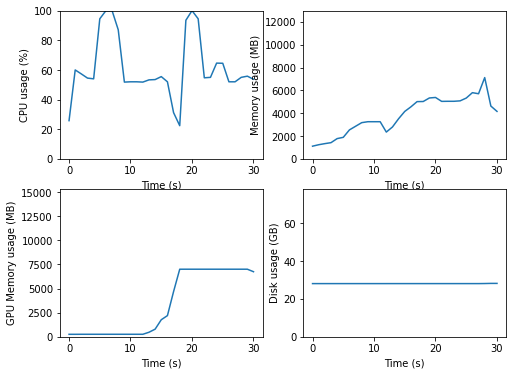

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428073689858811092699/1.3.6.1.4.1.14519.5.2.1.7009.9004.18829027842807368985881109269_2_OPA_GE_LS16_STANDARD_320_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.12s
Predicting...
  Predicted in 9.13s
Generating preview...
  Generated in 3.67s
Resampling...
Saving segmentations...
  Saved in 2.00s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 115092928 bytes into 2303881 bytes ==> 2.00%


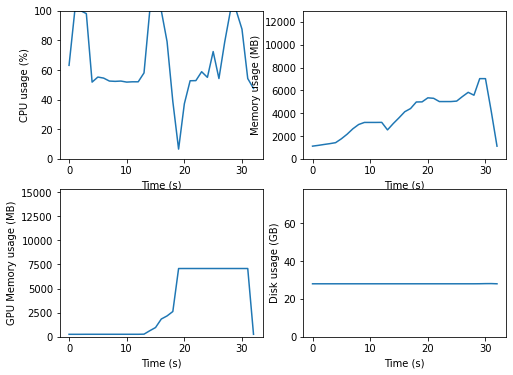

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831800529812210003081/1.3.6.1.4.1.14519.5.2.1.7009.9004.46300957483180052981221000308_2_OPA_GE_LS16_STANDARD_340_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.77s
Predicting...
  Predicted in 8.33s
Generating preview...
  Generated in 5.12s
Resampling...
Saving segmentations...
  Saved in 1.39s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 115879360 bytes into 2283447 bytes ==> 1.97%


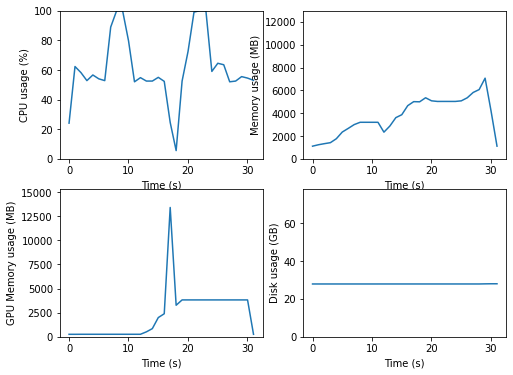

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147363329031787355411/1.3.6.1.4.1.14519.5.2.1.7009.9004.21032547814736332903178735541_2_OPA_GE_LS16_STANDARD_382_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.12s
Predicting...
  Predicted in 9.31s
Generating preview...
  Generated in 5.07s
Resampling...
Saving segmentations...
  Saved in 1.50s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 113782208 bytes into 2647527 bytes ==> 2.33%


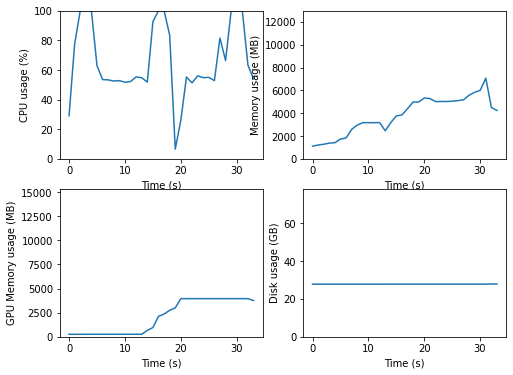

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140221092884829354405/1.3.6.1.4.1.14519.5.2.1.7009.9004.21767310514022109288482935440_2_OPA_GE_LS16_STANDARD_290_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 6.28s
Predicting...
  Predicted in 8.05s
Generating preview...
  Generated in 4.48s
Resampling...
Saving segmentations...
  Saved in 1.35s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 109587904 bytes into 2606506 bytes ==> 2.38%


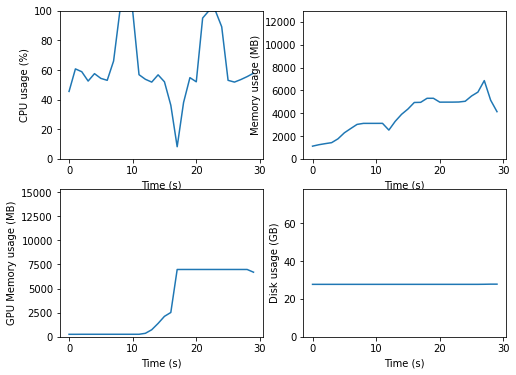

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271
/content/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370759657429616658271/1.3.6.1.4.1.14519.5.2.1.7009.9004.20157027537075965742961665827_2_OPA_GE_LS16_STANDARD_390_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Using 'fast' option: resampling to lower resolution (3mm)
Resampling...
  Resampled in 5.95s
Predicting...
  Predicted in 8.79s
Generating preview...
  Generated in 4.72s
Resampling...
Saving segmentations...
  Saved in 1.15s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Compressed 105917888 bytes into 2246313 bytes ==> 2.12%


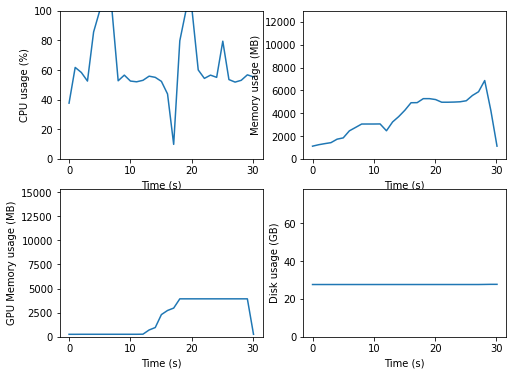

In [263]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'{curr_dir}/dcm2niix'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [264]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/Inference | lz4 > inferenceNiftiFiles.tar.lz4
archiving_time = time.time() - start_time


tar: Removing leading `/' from member names
/content/Inference/
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105/
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105.nii.lz4
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105/statistics_radiomics.json
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798721911743379690105/preview_total.png
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262/
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262.nii.lz4
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262/statistics_radiomics.json
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705859785782756947262/preview_total.png
/content/Inference/1.3.6.1.4

###Utilization Metrics

In [265]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['archiving_time']=archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 18876 bytes into 7448 bytes ==> 39.46%


,SeriesInstanceUID,total_segmentator_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.183901372798...,40.199911,0.127176,"[[[39.1, 46.7, 37.0, 43.9, 81.0, 85.4, 84.8, 5...","[[[1115.93359375, 1179.0234375, 1255.39453125,...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.428447723388672, 28.42660140991211, 28.4...",78.189842
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.207023621705...,28.832393,0.127176,"[[[30.3, 39.2, 73.9, 89.4, 87.5, 64.1, 37.4, 5...","[[[1104.25, 1158.94140625, 1236.6875, 1278.066...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 258.3125, 261...",[15360.0],b'Tesla T4',"[[[28.33407211303711, 28.334075927734375, 28.3...",78.189842
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.223093097797...,35.331063,0.127176,"[[[75.0, 62.5, 58.8, 54.2, 53.8, 54.3, 56.7, 5...","[[[1104.984375, 1227.41796875, 1324.453125, 14...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.25196075439453, 28.251964569091797, 28.2...",78.189842
3,1.3.6.1.4.1.14519.5.2.1.7009.9004.278216906052...,35.949421,0.127176,"[[[38.8, 58.1, 92.0, 95.0, 70.2, 66.5, 37.7, 5...","[[[1113.2265625, 1175.34375, 1256.51171875, 13...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.148372650146484, 28.14837646484375, 28.1...",78.189842
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.232142785210...,30.453464,0.127176,"[[[25.8, 60.0, 57.3, 54.5, 54.0, 94.5, 100.0, ...","[[[1113.4921875, 1240.7265625, 1337.25, 1421.3...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[28.054988861083984, 28.05499267578125, 28.0...",78.189842
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.188290278428...,31.846976,0.127176,"[[[63.1, 100.0, 100.0, 98.0, 51.8, 55.2, 54.5,...","[[[1116.46875, 1184.7890625, 1263.13671875, 13...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.955795288085938, 27.955799102783203, 27....",78.189842
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.463009574831...,31.049733,0.127176,"[[[24.1, 62.3, 58.2, 52.8, 56.6, 54.0, 52.8, 8...","[[[1114.16015625, 1239.9609375, 1334.76171875,...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.86117172241211, 27.861175537109375, 27.8...",78.189842
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.210325478147...,33.568828,0.127176,"[[[29.1, 77.4, 100.0, 100.0, 100.0, 62.9, 53.5...","[[[1114.91015625, 1212.59375, 1283.6953125, 13...",[12985.546875],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.765064239501953, 27.76506805419922, 27.7...",78.189842
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.217673105140...,29.332543,0.127176,"[[[45.5, 60.7, 58.8, 52.5, 57.5, 54.3, 53.0, 6...","[[[1115.82421875, 1241.3359375, 1336.3203125, ...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.663509368896484, 27.663585662841797, 27....",78.189842
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.201570275370...,30.059959,0.127176,"[[[37.6, 61.7, 58.3, 52.5, 85.6, 100.0, 100.0,...","[[[1114.76953125, 1241.30078125, 1336.9921875,...",[12985.546875],"[[[258.3125, 258.3125, 261.1875, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[27.571998596191406, 27.572002410888672, 27....",78.189842
